<a href="https://colab.research.google.com/github/Mchoon84/AIFFEL_guest_cr/blob/main/Exploration/Ex04/Ex04_image_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 이미지 생성 프로젝트

CIFAR-10 데이터셋을 활용한 DCGAN(Deep Convolutional Generative Adversarial Network) 구현 프로젝트입니다.

## 목차
1. [작업환경 구성](#STEP-1-작업환경-구성하기)
2. [데이터셋 구성](#STEP-2-데이터셋-구성하기)
3. [생성자 모델 구현](#STEP-3-생성자-모델-구현하기)
4. [판별자 모델 구현](#STEP-4-판별자-모델-구현하기)
5. [손실함수와 최적화 함수](#STEP-5-손실함수와-최적화-함수-구현하기)
6. [훈련과정 상세 기능](#STEP-6-훈련과정-상세-기능-구현하기)
7. [학습 과정 진행](#STEP-7-학습-과정-진행하기)
8. [GAN 훈련 과정 개선](#STEP-8-GAN-훈련-과정-개선하기)  

## STEP 1. 작업환경 구성하기

In [1]:
import tensorflow
import imageio

print(tensorflow.__version__)
print(imageio.__version__)

# 드라이브 마운팅
from google.colab import drive
drive.mount('/content/drive')

import os
# 디렉토리 생성
os.makedirs('/content/aiffel/dcgan_newimage/cifar10/generated_samples', exist_ok=True)
os.makedirs('/content/aiffel/dcgan_newimage/cifar10/training_checkpoints', exist_ok=True)
os.makedirs('/content/aiffel/dcgan_newimage/cifar10/training_history', exist_ok=True)

2.18.0
2.37.0
Mounted at /content/drive


STEP 2. 데이터셋 구성하기

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
(50000, 32, 32, 3)


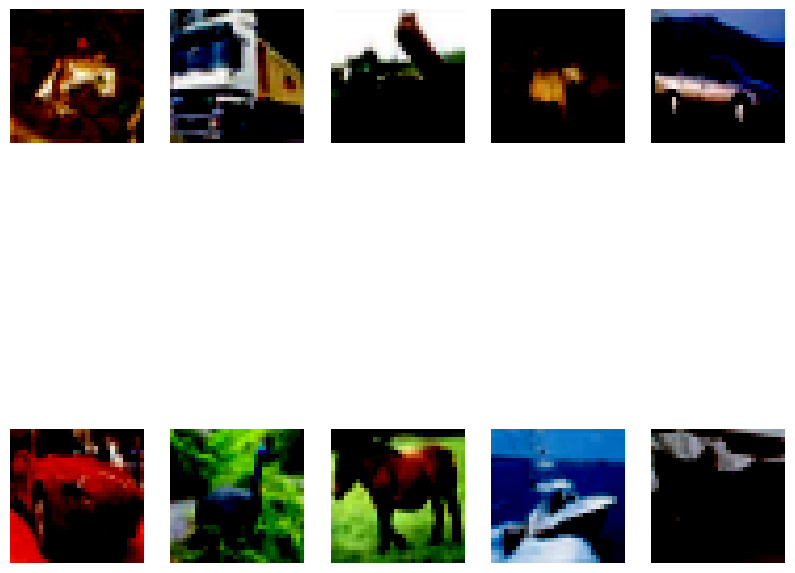

Training dataset batch size: 1563


In [2]:
# TensorFlow 라이브러리 임포트
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# CIFAR-10 데이터셋을 로드
cifar10 = tf.keras.datasets.cifar10

# 훈련 데이터(train_x)와 테스트 데이터(test_x)를 로드하고, 이미지와 라벨을 분리
(train_x, _), (test_x, _) = cifar10.load_data()

# 훈련 데이터의 shape을 출력하여 데이터 크기 확인
print(train_x.shape)  # (50000, 32, 32, 3)

# 데이터 로드 및 필터링 (선택적 레이블 필터링)
def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label is not None:
        # 특정 레이블만 필터링
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label'])
        df = df[df['label'] == label]
        train_x = np.array([i for i in list(df['image'])])

        df = pd.DataFrame(list(zip(test_x, test_y)), columns=['image', 'label'])
        df = df[df['label'] == label]
        test_x = np.array([i for i in list(df['image'])])
    return train_x, test_x

# CIFAR-10 데이터 로드 (여기서는 특정 레이블을 필터링하지 않음)
train_x, test_x = load_data()

# 이미지를 -1, 1 범위로 정규화
train_x = (train_x / 127.5) - 1.0  # 0-255 범위를 -1, 1로 변환
test_x = (test_x / 127.5) - 1.0

# 데이터 시각화 (임의의 10개 이미지 출력)
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i])  # 정규화된 이미지를 출력
    plt.axis('off')
plt.show()

# tf.data.Dataset을 사용하여 미니배치 데이터셋 생성
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_x).batch(BATCH_SIZE)

# 학습 데이터셋 크기 확인
print(f"Training dataset batch size: {len(train_dataset)}")

## STEP 3. 생성자 모델 구현하기

In [3]:
from tensorflow.keras import layers, Model, Input

# 노이즈 차원 정의 (여기서 정의해서 모든 함수에서 사용할 수 있게 함)
noise_dim = 100

def make_generator_model():
    # 첫 번째 레이어는 Input으로 정의
    model_input = Input(shape=(noise_dim,))
    x = layers.Dense(8 * 8 * 256, use_bias=False)(model_input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    # Reshape 레이어
    x = layers.Reshape((8, 8, 256))(x)

    # Conv2DTranspose 레이어
    x = layers.Conv2DTranspose(128, kernel_size=5, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    x = layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    x = layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', use_bias=False, activation='tanh')(x)

    # 모델 반환
    model = Model(model_input, x)
    return model

# 생성자 모델 만들기
generator = make_generator_model()

# 랜덤 노이즈 입력
noise = tf.random.normal([1, noise_dim])

# 생성된 이미지 출력
generated_image = generator(noise, training=False)

# 생성된 이미지의 shape 출력
print("Generated image shape: ", generated_image.shape)  # (1, 32, 32, 3)

Generated image shape:  (1, 32, 32, 3)


## STEP 4. 판별자 모델 구현하기

In [5]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # 첫 번째 Conv2D 레이어
    model.add(layers.Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=(32, 32, 3)))
    model.add(layers.LeakyReLU(negative_slope=0.2))
    model.add(layers.Dropout(0.3))

    # 두 번째 Conv2D 레이어
    model.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(layers.LeakyReLU(negative_slope=0.2))
    model.add(layers.Dropout(0.3))

    # Flatten 레이어
    model.add(layers.Flatten())

    # 마지막 Dense 레이어 (sigmoid 활성화 제거 - from_logits=True와 일치시키기 위함)
    model.add(layers.Dense(1))

    return model

# 판별자 모델 생성
discriminator = make_discriminator_model()

# 랜덤 이미지 (이전에 생성된 이미지 사용)
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

# 생성된 이미지를 판별자 모델에 입력
discriminator_output = discriminator(generated_image, training=False)

# 판별자 출력 확인
print("Discriminator output: ", discriminator_output)

Discriminator output:  tf.Tensor([[0.0018968]], shape=(1, 1), dtype=float32)


## STEP 5. 손실함수와 최적화 함수 구현하기

In [7]:
# 판별자 손실 함수
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# 생성자 손실 함수
def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

# 정확도 계산 함수 (from_logits=True에 맞게 수정)
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(real_output > 0, tf.float32))  # logit > 0 이면 실제로 예측
    fake_accuracy = tf.reduce_mean(tf.cast(fake_output < 0, tf.float32))  # logit < 0 이면 가짜로 예측
    return real_accuracy, fake_accuracy

# 최적화 함수 정의
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## STEP 6. 훈련과정 상세 기능 구현하기

In [8]:
import time
import os
import numpy as np
import tensorflow as tf
from IPython import display
import matplotlib.pyplot as plt

# 모델 저장 경로 설정
base_dir = '/content/aiffel/dcgan_newimage/cifar10'
checkpoint_dir = os.path.join(base_dir, 'training_checkpoints')
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Checkpoint 설정
checkpoint = tf.train.Checkpoint(generator=generator, discriminator=discriminator,
                                generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer)

# 시드 노이즈 정의 (이미지 생성용)
seed = tf.random.normal([1, noise_dim])

# 학습 진행 중 이미지 생성 및 저장
def generate_and_save_images(model, epoch, iteration, test_input):
    predictions = model(test_input, training=False)
    predictions = (predictions * 127.5) + 127.5  # 역정규화
    predictions = predictions.numpy().astype(np.uint8)

    # 저장 경로 설정
    img_path = os.path.join(base_dir, 'generated_samples', f'epoch_{epoch}_iter_{iteration}.png')
    plt.figure(figsize=(4, 4))
    plt.imshow(predictions[0])
    plt.axis('off')
    plt.savefig(img_path)
    plt.close()

# 학습 히스토리 그리기
def draw_train_history(history, epoch):
    plt.figure(figsize=(10, 5))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history['gen_loss'], label='Generator Loss')
    plt.plot(history['disc_loss'], label='Discriminator Loss')
    plt.title('Losses')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history['real_accuracy'], label='Real Accuracy')
    plt.plot(history['fake_accuracy'], label='Fake Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()

    # 파일로 저장
    history_img_path = os.path.join(base_dir, 'training_history', f'history_epoch_{epoch}.png')
    plt.tight_layout()
    plt.savefig(history_img_path)
    plt.close()

# 학습 함수 (값을 반환하도록 수정)
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # 명시적으로 값을 반환
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

# 모델 초기화
# 더미 데이터로 모델 호출하여 변수 초기화
dummy_noise = tf.random.normal([BATCH_SIZE, noise_dim])
dummy_images = next(iter(train_dataset))

# @tf.function 없이 변수 생성
with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    dummy_generated_images = generator(dummy_noise, training=False)
    dummy_real_output = discriminator(dummy_images, training=False)
    dummy_fake_output = discriminator(dummy_generated_images, training=False)

In [10]:
# 훈련
def train(train_dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss': [], 'disc_loss': [], 'real_accuracy': [], 'fake_accuracy': []}
    # 에포크별 통계 저장용 리스트 추가
    epoch_stats = []

    for epoch in range(epochs):
        epoch_start = time.time()
        # 에포크별 측정값 저장할 리스트
        epoch_gen_losses = []
        epoch_disc_losses = []
        epoch_real_accs = []
        epoch_fake_accs = []

        for it, image_batch in enumerate(train_dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            # 에포크별 통계용 데이터 추가
            epoch_gen_losses.append(gen_loss)
            epoch_disc_losses.append(disc_loss)
            epoch_real_accs.append(real_accuracy)
            epoch_fake_accs.append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch + 1, it + 1, seed)
                print(f'Epoch {epoch + 1} | Iter {it + 1}')
                print(f'Time for epoch {epoch + 1}: {int(time.time() - epoch_start)} sec')

        # 에포크 종료 시 평균 통계 계산
        avg_gen_loss = tf.reduce_mean(epoch_gen_losses).numpy()
        avg_disc_loss = tf.reduce_mean(epoch_disc_losses).numpy()
        avg_real_acc = tf.reduce_mean(epoch_real_accs).numpy()
        avg_fake_acc = tf.reduce_mean(epoch_fake_accs).numpy()
        avg_total_acc = (avg_real_acc + avg_fake_acc) / 2

        # 에포크 통계 저장
        epoch_stats.append({
            'epoch': epoch + 1,
            'gen_loss': avg_gen_loss,
            'disc_loss': avg_disc_loss,
            'real_acc': avg_real_acc,
            'fake_acc': avg_fake_acc,
            'total_acc': avg_total_acc
        })

        # 에포크 요약 출력
        print('\n' + '=' * 50)
        print(f'Epoch {epoch + 1}/{epochs} Summary:')
        print(f'Generator Loss: {avg_gen_loss:.4f}')
        print(f'Discriminator Loss: {avg_disc_loss:.4f}')
        print(f'Real Accuracy: {avg_real_acc:.4f}')
        print(f'Fake Accuracy: {avg_fake_acc:.4f}')
        print(f'Total Accuracy: {avg_total_acc:.4f}')
        print('=' * 50 + '\n')

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print(f'Time for training: {int(time.time() - start)} sec')

        draw_train_history(history, epoch)

    # 학습 완료 후 에포크별 통계 출력
    print('\n' + '#' * 50)
    print('훈련 완료! 에포크별 정확도 요약:')
    print('#' * 50)

    import pandas as pd
    stats_df = pd.DataFrame(epoch_stats)
    print(stats_df)

    # CSV 파일로 저장
    stats_path = os.path.join(base_dir, 'training_history', 'epoch_stats.csv')
    stats_df.to_csv(stats_path, index=False)
    print(f'에포크 통계가 저장되었습니다: {stats_path}')

    # 에포크별 정확도 그래프
    plt.figure(figsize=(10, 6))
    plt.plot(stats_df['epoch'], stats_df['real_acc'], 'g-', label='실제 이미지 정확도')
    plt.plot(stats_df['epoch'], stats_df['fake_acc'], 'r-', label='가짜 이미지 정확도')
    plt.plot(stats_df['epoch'], stats_df['total_acc'], 'b-', label='전체 정확도')
    plt.axhline(y=0.5, color='gray', linestyle='--', label='무작위 추측 (0.5)')

    plt.xlabel('에포크')
    plt.ylabel('정확도')
    plt.title('에포크별 판별자 정확도')
    plt.legend()
    plt.grid(True)

    # 그래프 저장
    acc_plot_path = os.path.join(base_dir, 'training_history', 'accuracy_per_epoch.png')
    plt.savefig(acc_plot_path)
    plt.close()
    print(f'정확도 그래프가 저장되었습니다: {acc_plot_path}')

## STEP 7. 학습 과정 진행하기

In [13]:
save_every = 5
EPOCHS = 50

train(train_dataset, EPOCHS, save_every=5)

Time for training: 1054 sec

##################################################
훈련 완료! 에포크별 정확도 요약:
##################################################
    epoch  gen_loss  disc_loss  real_acc  fake_acc  total_acc
0       1  1.858544   0.675152  0.845230  0.910549   0.877889
1       2  1.614093   0.879518  0.787708  0.832594   0.810151
2       3  1.398563   0.987205  0.747681  0.793006   0.770343
3       4  1.157171   1.076801  0.706474  0.781830   0.744152
4       5  1.225565   1.065715  0.710133  0.782290   0.746211
5       6  1.270304   1.013807  0.730226  0.789807   0.760017
6       7  1.239774   1.047313  0.703335  0.784129   0.743732
7       8  1.277174   1.043649  0.712832  0.784009   0.748420
8       9  1.352067   0.994598  0.727667  0.798584   0.763126
9      10  1.323275   1.065162  0.707594  0.770194   0.738894
10     11  1.271683   1.071509  0.703235  0.763036   0.733135
11     12  1.224439   1.106847  0.691239  0.744982   0.718110
12     13  1.185646   1.118022  0.686300  0

<ipython-input-10-43bbe290be2a>:100: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.savefig(acc_plot_path)
<ipython-input-10-43bbe290be2a>:100: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  plt.savefig(acc_plot_path)
<ipython-input-10-43bbe290be2a>:100: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.savefig(acc_plot_path)
<ipython-input-10-43bbe290be2a>:100: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.savefig(acc_plot_path)
<ipython-input-10-43bbe290be2a>:100: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.savefig(acc_plot_path)
<ipython-input-10-43bbe290be2a>:100: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s) DejaVu Sans.
  plt.savefig(acc_plot_path)
<ipython-input-10-43bbe290be2a>:100: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missi

학습 결과 확인 및 생성된 이미지 시각화

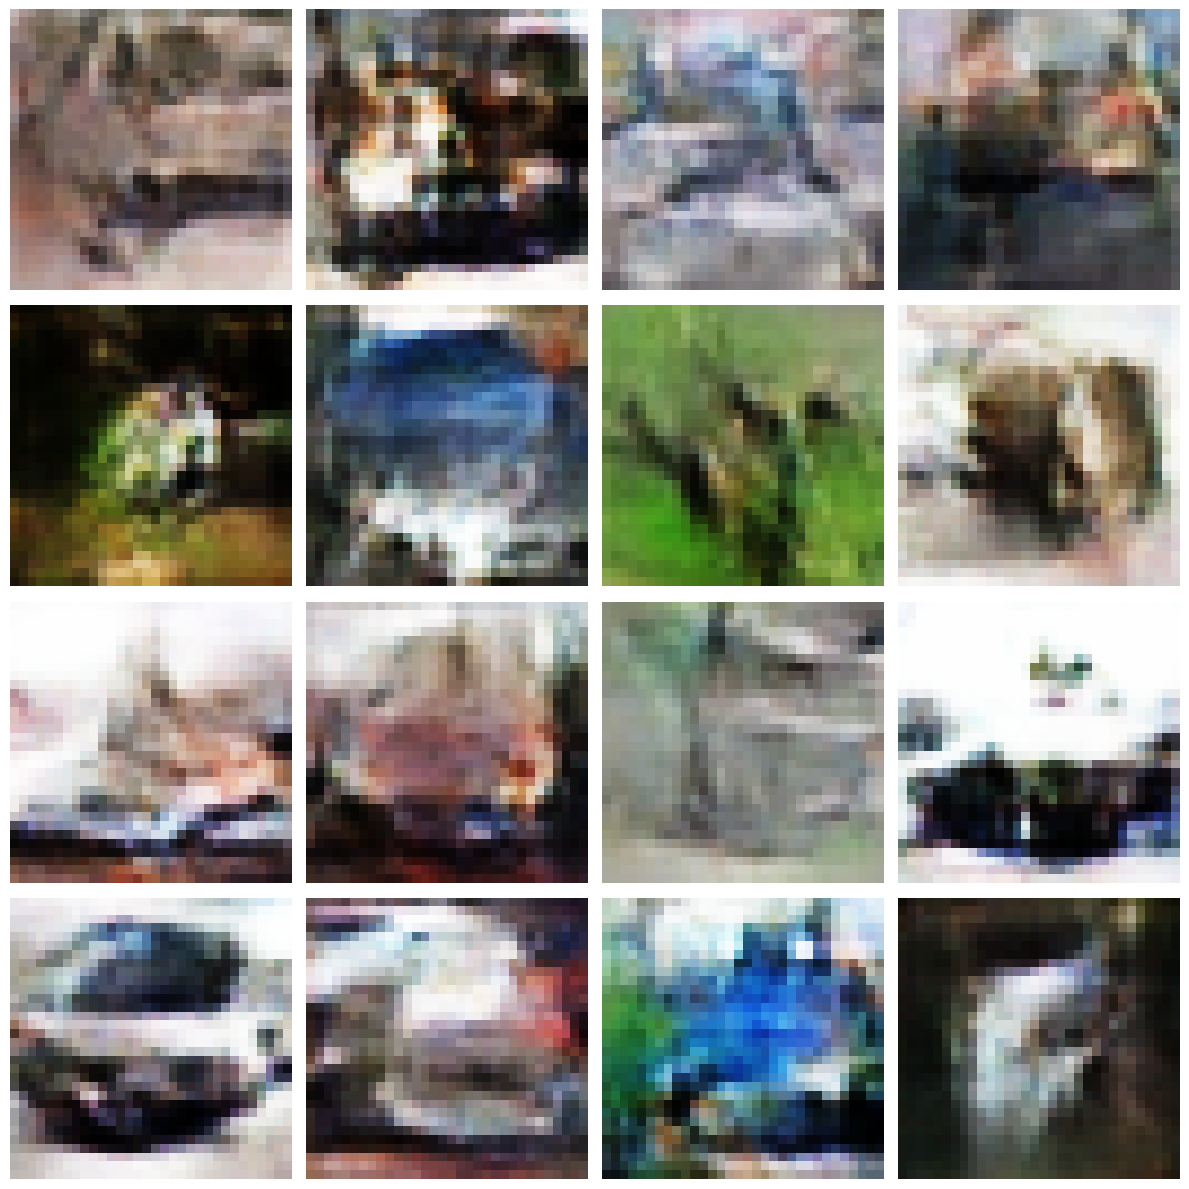

<Figure size 640x480 with 0 Axes>

In [15]:
# 저장된 체크포인트 로드
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# 여러 이미지 생성 및 시각화
def visualize_multiple_generated_images(num_images=16):
    plt.figure(figsize=(12, 12))

    for i in range(num_images):
        # 랜덤 노이즈로 이미지 생성
        random_noise = tf.random.normal([1, noise_dim])
        predictions = generator(random_noise, training=False)

        # -1~1 범위에서 0~255 범위로 변환
        predictions = (predictions * 127.5) + 127.5
        predictions = predictions.numpy().astype(np.uint8)

        # 서브플롯에 이미지 표시
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[0])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # 저장
    plt.savefig(os.path.join(base_dir, 'generated_samples', 'final_generated_grid.png'))

# 16개의 이미지 생성 및 시각화
visualize_multiple_generated_images(16)

학습 과정 그래프 및 애니메이션 생성

총 1601개의 샘플 이미지 발견
GIF 애니메이션이 저장되었습니다: /content/aiffel/dcgan_newimage/cifar10/generated_samples/training_progress.gif


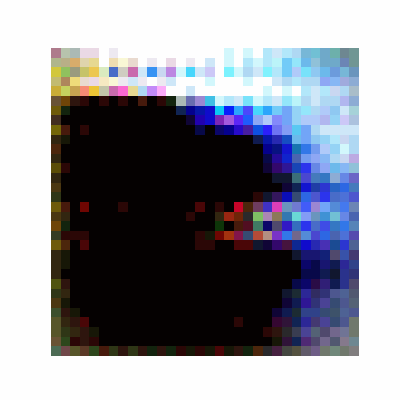

In [16]:
# 에포크별 이미지 진화를 GIF로 만들기
import imageio.v2 as imageio
import glob
import re
import os

# 에포크 번호 추출 함수
def get_epoch_iter(filename):
    match = re.search(r'epoch_(\d+)_iter_(\d+)', filename)
    if match:
        return int(match.group(1)), int(match.group(2))
    return 0, 0

# 샘플 이미지 파일 찾기
sample_files = glob.glob(os.path.join(base_dir, 'generated_samples', 'epoch_*.png'))
print(f"총 {len(sample_files)}개의 샘플 이미지 발견")

if sample_files:
    # 에포크별로 정렬
    sample_files.sort(key=get_epoch_iter)

    # 에포크별 대표 이미지 선택 (각 에포크의 마지막 반복)
    epoch_images = {}
    for file in sample_files:
        epoch, iter_num = get_epoch_iter(file)
        if epoch not in epoch_images or get_epoch_iter(epoch_images[epoch])[1] < iter_num:
            epoch_images[epoch] = file

    sorted_epochs = sorted(epoch_images.keys())
    selected_files = [epoch_images[epoch] for epoch in sorted_epochs]

    # GIF 파일 경로
    gif_path = os.path.join(base_dir, 'generated_samples', 'training_progress.gif')

    # 이미지 읽기 및 GIF 생성
    images = []
    for file in selected_files:
        images.append(imageio.imread(file))

    # GIF 저장 (각 프레임 0.5초 유지)
    imageio.mimsave(gif_path, images, duration=0.5)
    print(f"GIF 애니메이션이 저장되었습니다: {gif_path}")

    # 코랩에서 GIF 표시
    from IPython.display import Image, display
    display(Image(gif_path))

## STEP 8. GAN 훈련 과정 개선하기  
### 이전 훈련 과정의 문제점 분석

**Discriminator가 중반 이후 너무 강해짐**
- 초기(1~2 epoch)에는 fake accuracy가 0.88, real accuracy가 0.82로 비교적 균형 잡힌 상태였음
- 그러나 3 epoch 이후부터 fake accuracy가 급격히 감소하여 0.70~0.75 수준에서 정체됨
- real accuracy는 30 epoch 이후로 0.63~0.66에서 정체, fake accuracy는 소폭 상승해 0.75 전후에서 유지
- 이는 Discriminator가 점차 generator보다 우위를 점하며 학습 주도권을 잡은 상태를 의미함
- Generator는 더 이상 Discriminator를 잘 속이지 못하며, 이는 생성 이미지 품질 저하로 이어질 수 있음

**Loss 진동 및 수렴 문제**
- 초기 손실(G: 1.66, D: 0.74)에서 3 ~ 5 epoch까지 D-loss가 1.2 이상으로 급증, G-loss는 감소하다 다시 상승하는 형태
- 20 epoch 이후로 gen_loss는 1.2~1.3 사이에서 오르내리며 정체, disc_loss도 1.0 이상에서 고착
- 즉, 두 모델 모두 일정 수준에서 고립되어 학습이 진행되지 않는 상태, 손실값이 서로 반응하지 않고 진동하며 멈춘 듯한 패턴을 보임
- 이는 GAN 특유의 mode collapse 혹은 gradient vanishing 가능성도 있음

**전체 정확도(total_acc) 감소 후 정체**
- 초기 total_acc: 0.85 (epoch 1) → epoch 3 ~ 6에서 급락 (~0.70)
- 이후 전체 정확도는 40 epoch 이후에도 0.70 전후에서 머무름, 의미 있는 상승 없음
- 모델이 일정 수준 이상의 판별/생성 성능을 넘어가지 못하고 '정체 구간'에 빠진 상태

**Generator 회복 시도 관찰되나 실패**
- 20 ~ 21 epoch 사이 잠시 fake accuracy가 0.79까지 상승하며 generator가 회복되는 듯 보였으나
- 이후 다시 하락하며 0.73 ~ 0.76 사이에서 오르내림
- 이처럼 generator가 가끔 회복을 시도하지만 discriminator가 더 빠르게 적응하며 다시 밀리는 양상을 보임

### 모델 구조 또는 학습 과정 개선 방안

개선을 위해 다음 조치를 적용함:

**학습률 조정**
- Discriminator의 learning rate를 낮춤 → 1e-4 → 1e-5로 변경
- 너무 빨리 학습하는 것을 막아 Generator가 조금 더 따라올 수 있도록 유도

**Label Smoothing 적용**
- Discriminator에 Label Smoothing 적용
- Real label을 1.0이 아닌 0.9로 설정
- 너무 확신을 가지지 않도록 하여 Generator 학습 안정화

**Optimizer 변경**
- Adam의 beta 값을 (0.5, 0.999)로 조정
- DCGAN 논문에 따라 안정적인 학습 유도

**Generator 업샘플링 개선**
- Conv2DTranspose 레이어 구조를 조금 더 깊게 조정하여 고해상도 생성 유도


## 회고

## 배운 점

- GAN은 생성자와 판별자가 경쟁 구조를 이루며 학습하고, 서로의 성능을 끌어올리는 방식으로 발전함  
- 모델이 단순한 예측을 넘어서 상호작용을 통해 더 나은 결과를 만들어내는 방식이 매우 흥미로움  
- 생성자가 판별자를 속이도록 학습하고, 판별자는 이를 구분하려 하며, 이 과정이 반복되면서 점점 더 현실감 있는 이미지를 만들어냄  
- GAN은 특히 가볍고 실용적인 서비스 구현에 적합하며, 구조적 이해를 바탕으로 다양한 응용 가능성이 존재함  

## 아쉬운 점

- 생성자와 판별자 간의 학습 속도 불균형으로 인해 모델 학습이 불안정해지는 경우가 발생함  
- 생성자가 판별자를 속였더라도 결과물의 품질이 항상 개선되지는 않아 모델의 성능을 객관적으로 판단하기 어려움  
- 하이퍼파라미터 조정과 학습률 설정이 결과에 큰 영향을 주었고, 실험을 반복하며 많은 시간이 소요됨  
- 기대했던 서비스를 완성하지 못했거나 모델 훈련을 끝까지 진행하지 못한 점이 아쉬움  

## 느낀 점

- 생성자와 판별자의 대립적 관계가 마치 예술가와 비평가, 또는 연주자와 지휘자처럼 느껴졌으며, 이를 통해 창의적인 성장이 이루어진다는 점이 인상적이었음  
- GAN은 단순한 기술을 넘어 개념적으로도 철학적인 요소가 담겨 있는 흥미로운 구조임  
- 훈련이 잘 진행되었을 때조차 정확도가 0.5로 수렴하는 것이 좋은 결과라는 개념이 새롭고 인상적이었음  
- 생성 모델을 통해 실용적인 서비스를 구현할 수 있는 가능성과 그 응용의 폭에 감탄함  

## 어려웠던 점

- 모델 훈련 중 어느 시점에서 조정을 해야 할지 판단하는 것이 어렵고, 최적화 과정이 복잡함  
- 하이퍼파라미터 튜닝과 학습률 조정이 민감하게 작용하며 실험의 반복과 오류가 많았음  
- 생성된 결과의 품질을 정량적으로 판단하기가 어려워 성능 개선 여부를 확인하는 데 한계가 있었음  
- 실제 서비스 구현 과정에서 기술적 한계와 시간적 제약으로 인해 기획한 결과물을 끝까지 완성하지 못했음
